In [1]:
pip install torch torchvision matplotlib --quiet

In [2]:
# [1] Import core libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
# [2] Load MNIST data
transform = transforms.Compose([transforms.ToTensor()])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.83MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 161kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.65MB/s]


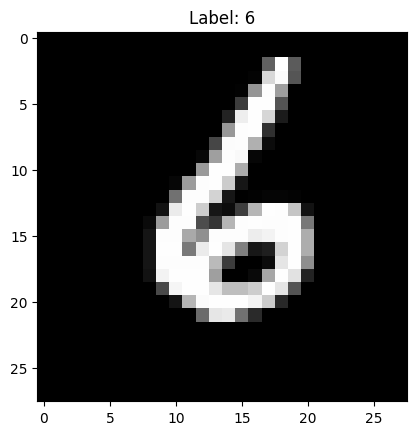

In [4]:
# [3] Show one image
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

plt.imshow(example_data[0][0], cmap="gray")
plt.title(f"Label: {example_targets[0]}")
plt.show()

In [5]:
# [4] Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)   # input → hidden
        self.fc2 = nn.Linear(128, 64)      # hidden → hidden
        self.fc3 = nn.Linear(64, 10)       # hidden → output (10 digits)

    def forward(self, x):
        x = x.view(-1, 28*28)  # flatten image
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [6]:
# [5] Initialize components
model = SimpleNN()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.NLLLoss()

In [7]:
# [6] Train the model
epochs = 3
for epoch in range(epochs):
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()          # reset gradients
        output = model(data)           # forward pass
        loss = loss_fn(output, target) # compute loss
        loss.backward()                # backpropagation
        optimizer.step()               # update weights
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/3, Loss: 0.3406
Epoch 2/3, Loss: 0.1421
Epoch 3/3, Loss: 0.0998


In [8]:
# [7] Test the model
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 96.92%


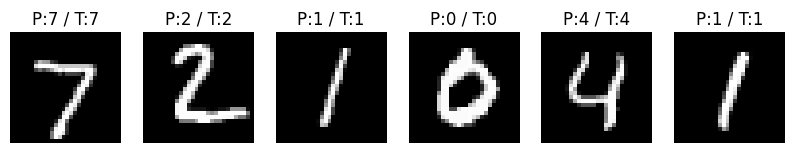

In [9]:
# [8] Visualize predictions
images, labels = next(iter(test_loader))
output = model(images)
_, preds = torch.max(output, 1)

plt.figure(figsize=(10, 4))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(images[i][0], cmap='gray')
    plt.title(f"P:{preds[i].item()} / T:{labels[i].item()}")
    plt.axis('off')
plt.show()

In [11]:
# [9] Slightly deeper and wider network
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedNN(nn.Module):
    def __init__(self):
        super(ImprovedNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)   # more neurons
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x, dim=1)


In [12]:
model = ImprovedNN()


In [13]:
print(model)

ImprovedNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)


In [14]:
# [10] New training setup
model = ImprovedNN()
optimizer = optim.Adam(model.parameters(), lr=0.0008)  # smaller learning rate
loss_fn = nn.NLLLoss()

# Train longer
epochs = 5
for epoch in range(epochs):
    total_loss = 0
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1/5, Loss: 0.3381
Epoch 2/5, Loss: 0.1237
Epoch 3/5, Loss: 0.0808
Epoch 4/5, Loss: 0.0595
Epoch 5/5, Loss: 0.0449


In [15]:
# [11] Add dropout layers to reduce overfitting
class RegularizedNN(nn.Module):
    def __init__(self):
        super(RegularizedNN, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)


In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 97.61%


In [17]:
# [12] Import metrics and visualization tools
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

In [18]:
# [13] Get all predictions and labels
all_preds = []
all_labels = []

with torch.no_grad():
    for data, target in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(target.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

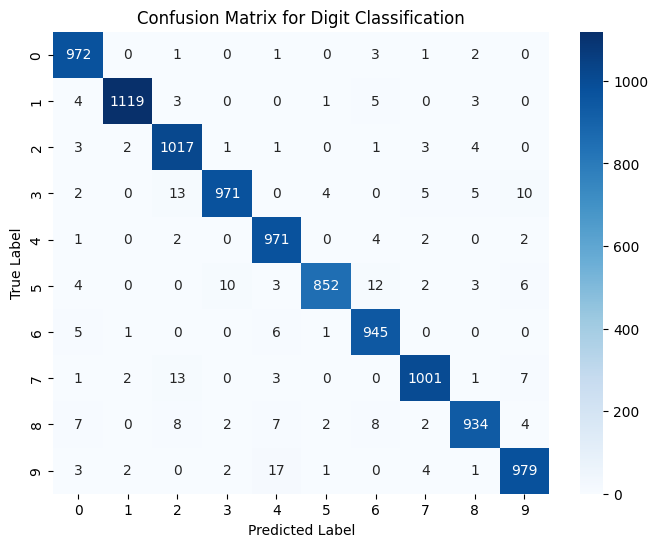

In [19]:
# [14] Compute and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Digit Classification')
plt.show()

In [20]:
# [15] Generate a detailed classification report
report = classification_report(all_labels, all_preds)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.99      0.97      1032
           3       0.98      0.96      0.97      1010
           4       0.96      0.99      0.98       982
           5       0.99      0.96      0.97       892
           6       0.97      0.99      0.98       958
           7       0.98      0.97      0.98      1028
           8       0.98      0.96      0.97       974
           9       0.97      0.97      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



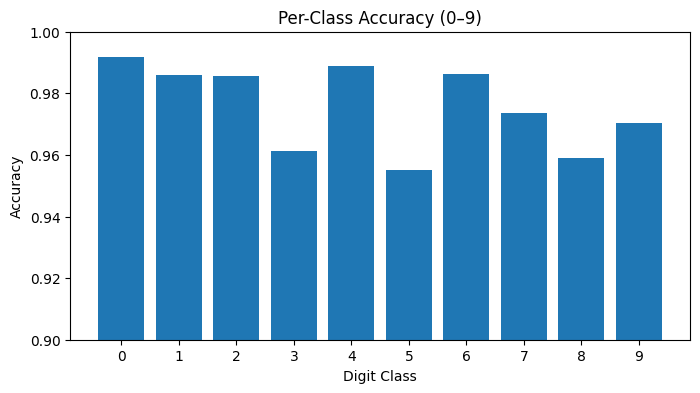

In [21]:
# [16] Per-class accuracy bar chart
class_accuracy = []
for i in range(10):
    correct = np.sum((all_labels == i) & (all_preds == i))
    total = np.sum(all_labels == i)
    class_accuracy.append(correct / total)

plt.figure(figsize=(8, 4))
plt.bar(range(10), class_accuracy)
plt.xticks(range(10))
plt.ylim(0.9, 1.0)
plt.title("Per-Class Accuracy (0–9)")
plt.xlabel("Digit Class")
plt.ylabel("Accuracy")
plt.show()